# Classificação de Imagens com CNN no CIFAR-10

Este notebook é uma versão aprimorada do projeto base, incorporando melhorias sugeridas em exemplos anteriores. As alterações incluem:

- Data augmentation
- Arquitetura CNN otimizada
- Uso de Dropout e Batch Normalization
- Ajuste de hiperparâmetros
- Visualização de métricas de desempenho


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Usando dispositivo:', device)


Usando dispositivo: cpu


##🔄 Transformações nas Imagens
As transformações aplicadas às imagens incluem:

  - ToTensor(): converte imagens PIL para tensores do PyTorch.

  - Normalize(): normaliza os canais de cor para que a média seja 0 e o desvio padrão seja 1, o que acelera e estabiliza o processo de treinamento.

In [11]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Files already downloaded and verified
Files already downloaded and verified


##📁 Carregamento do Dataset CIFAR-10
Aqui utilizamos o torchvision.datasets para baixar e preparar o conjunto de dados CIFAR-10. Esse dataset é composto por 60.000 imagens coloridas 32x32 divididas em 10 classes (avião, carro, pássaro, gato, etc.). Ele é particionado automaticamente entre dados de treino (50.000 imagens) e teste (10.000 imagens).

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

##📦 Criação dos DataLoaders

Os DataLoaders são responsáveis por iterar eficientemente sobre os dados em mini-batches. Aqui, usamos um batch size de 64 e embaralhamento dos dados de treino para melhor generalização.

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

##Visualização de algumas imagens


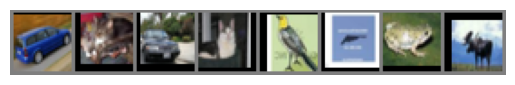

automobile cat automobile cat bird airplane frog deer


In [12]:
classes = train_dataset.classes

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images[:8]))
print(' '.join(classes[labels[j]] for j in range(8)))


##🧠 Definição da Arquitetura da CNN
Esta célula define a arquitetura da rede neural convolucional (CNN), com camadas convolucionais seguidas de pooling e camadas densas. A última camada possui 10 saídas correspondendo às 10 classes do CIFAR-10.

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = CNN().to(device)


##🛠️ Classe de Treinamento da CNN
Esta célula define a classe CNNTrainer, responsável por treinar e validar a CNN. Ela realiza o treinamento por épocas, armazena métricas de desempenho, aplica early stopping com base na perda de validação e salva o melhor modelo durante o processo.

In [14]:
class CNNTrainer:
    def __init__(self, model, train_loader, val_loader, device):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

        # Para guardar métricas
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train_epoch(self, optimizer, criterion):
        self.model.train()
        running_loss = 0
        correct = 0
        total = 0

        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = 100 * correct / total
        return epoch_loss, epoch_acc

    def validate(self, criterion):
        self.model.eval()
        running_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = 100 * correct / total
        return epoch_loss, epoch_acc

    def train(self, optimizer, criterion, scheduler=None, num_epochs=50, patience=15):
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in tqdm(range(num_epochs), desc="Treinando CNN"):
            train_loss, train_acc = self.train_epoch(optimizer, criterion)
            val_loss, val_acc = self.validate(criterion)

            if scheduler:
                scheduler.step(val_loss)

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(self.model.state_dict(), 'best_cnn_model.pth')
            else:
                patience_counter += 1

            if epoch % 5 == 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(f"[Época {epoch:02d}] Train Loss: {train_loss:.4f}, "
                      f"Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                      f"Val Acc: {val_acc:.2f}%, LR: {current_lr:.6f}")

            if patience_counter >= patience:
                print(f"Early stopping ativado na época {epoch}")
                break

        self.model.load_state_dict(torch.load('best_cnn_model.pth'))
        return self.model


##⚙️ Função de Perda, Otimizador e Scheduler
Esta célula define a função de perda CrossEntropyLoss, o otimizador Adam com taxa de aprendizado de 0.001 e o scheduler ReduceLROnPlateau para ajuste dinâmico da taxa de aprendizado durante o treinamento.

In [16]:
trainer = CNNTrainer(model, train_loader, test_loader, device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

trained_model = trainer.train(optimizer, criterion, scheduler, num_epochs=10, patience=15)


Treinando CNN:  10%|█         | 1/10 [02:32<22:55, 152.84s/it]

[Época 00] Train Loss: 1.0282, Val Loss: 0.8169, Train Acc: 63.63%, Val Acc: 72.33%, LR: 0.001000


Treinando CNN:  60%|██████    | 6/10 [15:44<10:40, 160.16s/it]

[Época 05] Train Loss: 0.8970, Val Loss: 0.7557, Train Acc: 68.44%, Val Acc: 73.44%, LR: 0.001000


Treinando CNN: 100%|██████████| 10/10 [26:40<00:00, 160.04s/it]
<ipython-input-14-67cd3eb8f8a8>:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(

##📊 Avaliação no Conjunto de Teste
Esta célula avalia o desempenho do modelo no conjunto de teste, gerando previsões e comparando-as com os rótulos reais. Por fim, imprime um relatório de classificação com métricas como precisão, revocação e F1-score para cada classe.

In [17]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=classes))


              precision    recall  f1-score   support

    airplane       0.77      0.79      0.78      1000
  automobile       0.91      0.85      0.88      1000
        bird       0.72      0.59      0.65      1000
         cat       0.60      0.55      0.58      1000
        deer       0.74      0.72      0.73      1000
         dog       0.63      0.75      0.69      1000
        frog       0.73      0.86      0.79      1000
       horse       0.85      0.77      0.81      1000
        ship       0.81      0.90      0.85      1000
       truck       0.88      0.84      0.86      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



## 6. Matriz de confusão
Essa visualização ajuda a identificar padrões de confusão entre classes semelhantes (por exemplo, gato x cachorro) e pode direcionar melhorias no modelo, como:

    Balanceamento de dados por classe,

    Ajuste na arquitetura,

    Data augmentation específico para classes confundidas.


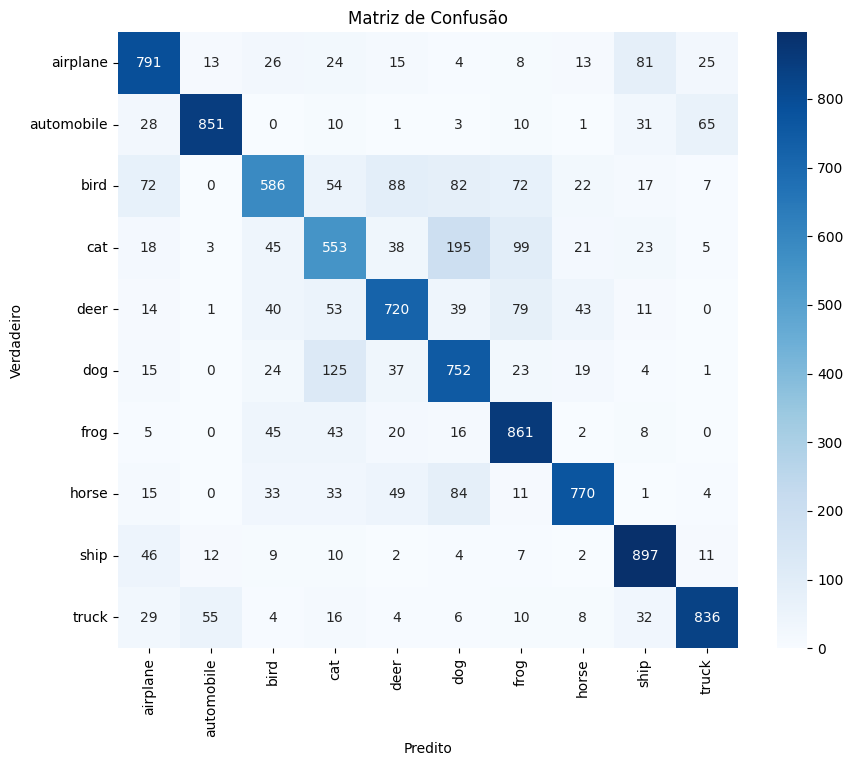

In [18]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()


## Evolução da Perda Durante o Treinamento

Durante o processo de treinamento, é fundamental acompanhar a **função de perda (loss function)** para verificar se o modelo está de fato aprendendo. Uma curva decrescente e estável indica que o modelo está convergindo. Caso contrário, pode ser necessário ajustar hiperparâmetros, normalização, ou revisar a arquitetura da rede.


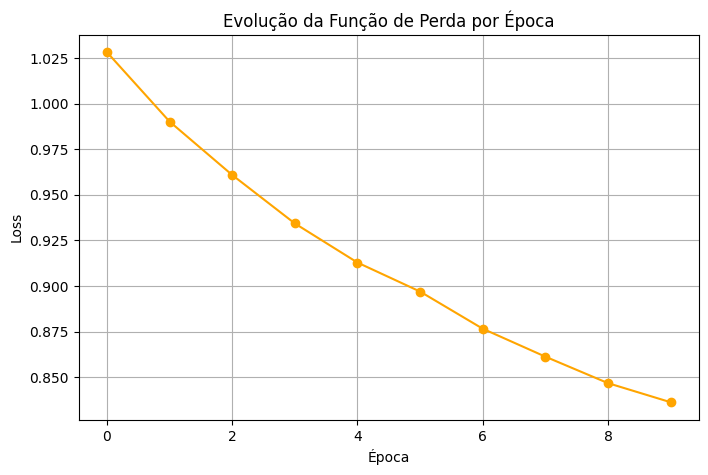

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(trainer.train_losses, marker='o', color='orange')
plt.title("Evolução da Função de Perda por Época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


## Visualização de Previsões Corretas e Incorretas

Além das métricas quantitativas, é interessante visualizar **quais imagens o modelo acertou e quais ele errou**, comparando rótulos verdadeiros e previstos. Isso ajuda a identificar padrões de erro, como confusão entre classes semelhantes (ex: gato vs cachorro).


In [23]:
def mostrar_exemplos(modelo, dataloader, acertou=True, maximo=6):
    modelo.eval()
    imagens_mostradas = 0
    with torch.no_grad():
        for imagens, rotulos in dataloader:
            imagens, rotulos = imagens.to(device), rotulos.to(device)
            saidas = modelo(imagens)
            _, predicoes = torch.max(saidas, 1)
            comparacao = predicoes == rotulos if acertou else predicoes != rotulos
            for i in range(len(imagens)):
                if comparacao[i]:
                    img = imagens[i].cpu()
                    img = img / 2 + 0.5  # desfaz normalização
                    npimg = img.numpy()
                    plt.imshow(np.transpose(npimg, (1, 2, 0)))
                    plt.title(f"Verdadeiro: {classes[rotulos[i]]} | Predito: {classes[predicoes[i]]}")
                    plt.axis('off')
                    plt.show()
                    imagens_mostradas += 1
                if imagens_mostradas >= maximo:
                    return


### 🔍 Exemplos de Previsões Corretas
Abaixo estão algumas imagens que o modelo classificou corretamente.


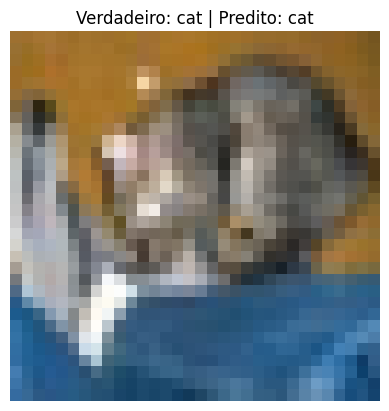

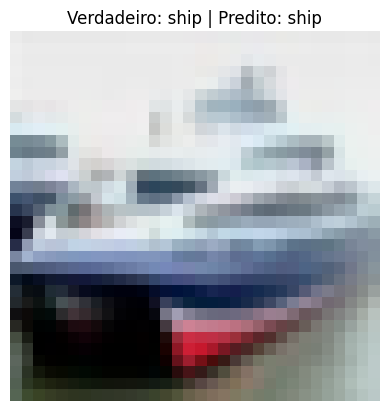

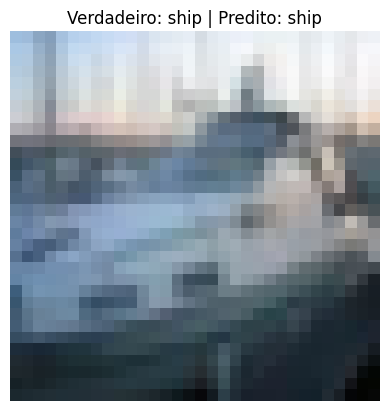

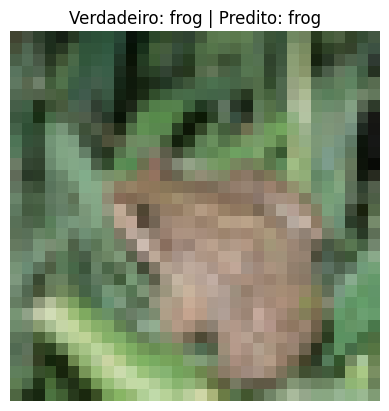

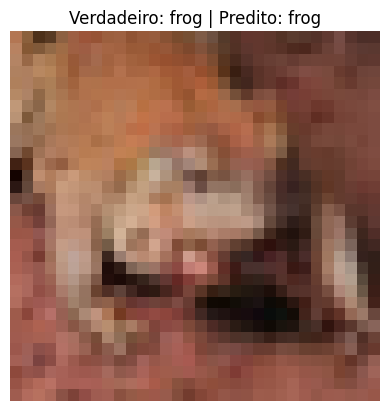

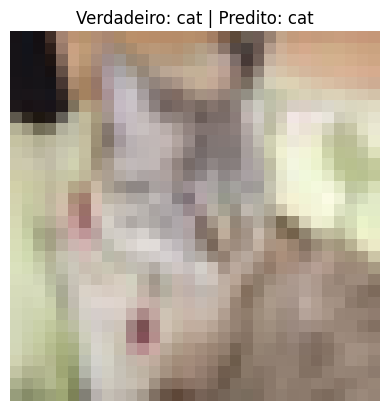

In [24]:
mostrar_exemplos(model, test_loader, acertou=True)


### ❌ Exemplos de Previsões Incorretas
Agora observamos imagens em que o modelo falhou, o que pode revelar limitações da arquitetura ou oportunidades para melhorar o pré-processamento.


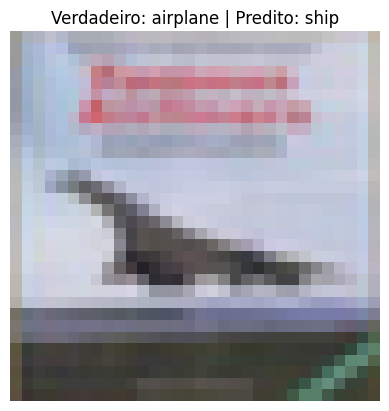

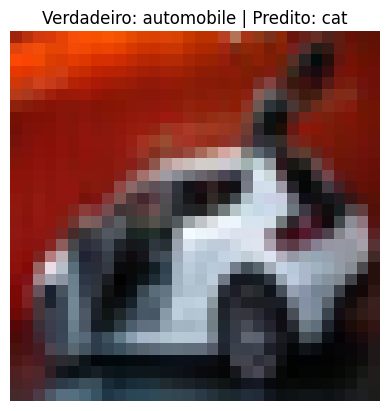

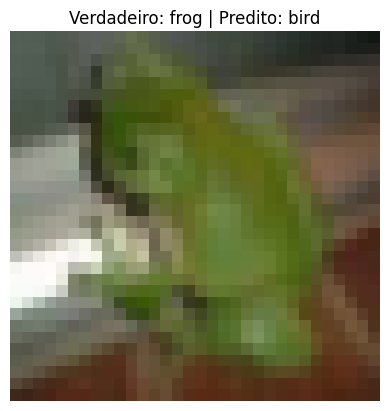

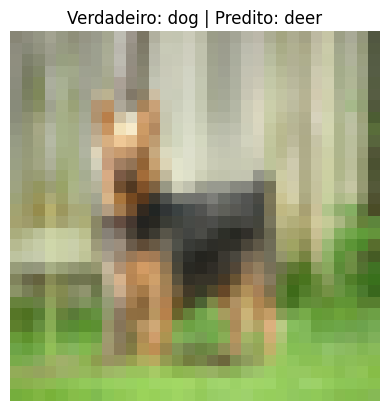

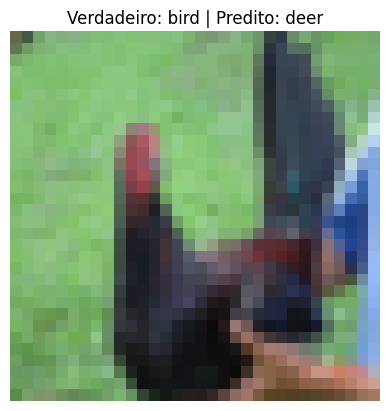

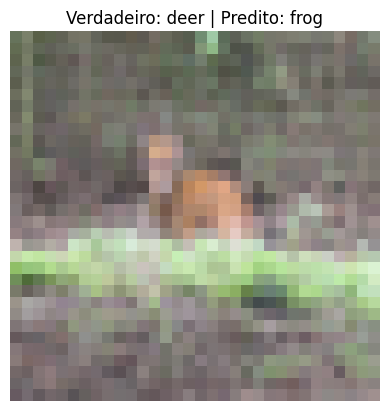

In [25]:
mostrar_exemplos(model, test_loader, acertou=False)


## Acurácia por Classe

Nem todas as classes são igualmente fáceis de aprender. Algumas podem ter maior variação intra-classe ou similaridade inter-classe. A seguir, analisamos a **acurácia de cada classe individualmente**, o que pode apontar onde o modelo tem maior dificuldade.


<ipython-input-26-0f34695cf0fb>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(acuracias.keys()), y=list(acuracias.values()), palette='viridis')


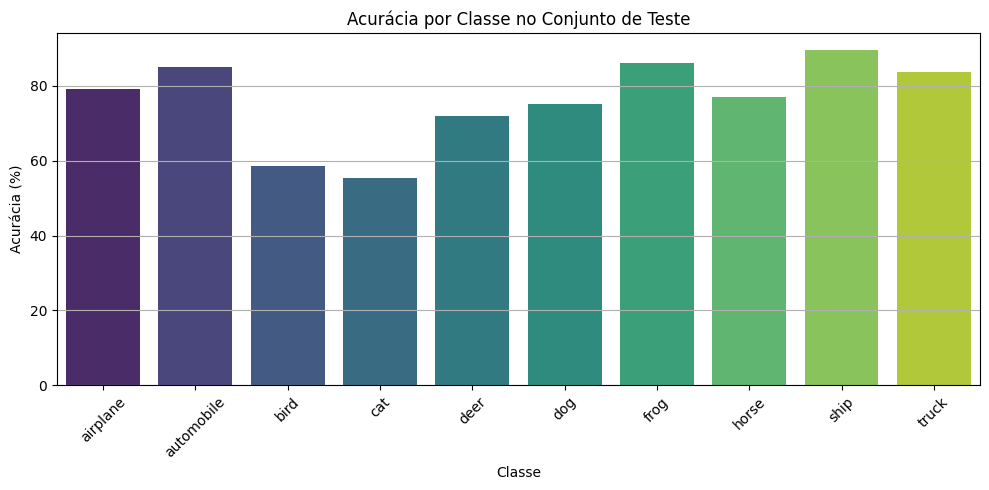

In [26]:
acertos_por_classe = {nome: 0 for nome in classes}
total_por_classe = {nome: 0 for nome in classes}

model.eval()
with torch.no_grad():
    for imagens, rotulos in test_loader:
        imagens, rotulos = imagens.to(device), rotulos.to(device)
        saidas = model(imagens)
        _, predicoes = torch.max(saidas, 1)
        for real, pred in zip(rotulos, predicoes):
            classe = classes[real]
            if real == pred:
                acertos_por_classe[classe] += 1
            total_por_classe[classe] += 1

acuracias = {k: 100 * acertos_por_classe[k] / total_por_classe[k] for k in classes}

plt.figure(figsize=(10, 5))
sns.barplot(x=list(acuracias.keys()), y=list(acuracias.values()), palette='viridis')
plt.ylabel("Acurácia (%)")
plt.xlabel("Classe")
plt.title("Acurácia por Classe no Conjunto de Teste")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
